# Sending and Receiving IR Signals

This PYNQ notebook implements a use-case for arbitrary low-speed signalling I/O.
It implements a IOP program to synthesize/capture waveforms from/to data in CMA buffers.
Contrary to naïve logic tracing that samples and stores values at a fixed (rather high) frequency, waveform data is stored here as a list of time intervals (i.e. number of system clock cycles) between signal transitions.
This allows to synthesize and capture low-speed waveforms efficiently.

The particular use-case implemented here is IR remote control message capture and replay.
Typical remote controls operate at frequencies of about 35 kHz.
This notebook expects a [IRTransceiver Pmod](https://github.com/s-holst/IRTransceiver) connected to PMODA.
If this module is not available, run a wire between Pin 0 (TX) and Pin 2 (RX) to create a loop-back.
The IOP program is designed to simultaneously send and receive data.

## 1. Use BaseOverlay and Load IOP Program

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pynq.overlays.base import BaseOverlay
from pynq import Xlnk

base = BaseOverlay('base.bit')
base.select_pmoda()
xlnk = Xlnk()

In [2]:
%%microblaze base.PMODA

#include <gpio.h>
#include <xtmrctr.h>
#include <yield.h>

// class-like object: wio
typedef int wio;

// maximum number of simultaneous instances
#define WIO_INST_COUNT 8

// instance variables
typedef struct wio_inst_type {

    unsigned int* tx_buffer;
    unsigned int tx_buffer_cur;
    unsigned int tx_buffer_len;
    unsigned int tx_target_time;
    unsigned int tx_await_wrap;
    gpio tx_pin;
    
    unsigned int* rx_buffer;
    unsigned int rx_buffer_cur;
    unsigned int rx_buffer_len;
    unsigned int rx_last_time;
    gpio rx_pin;
    
    unsigned int main_loop_running;
    
} wio_inst_type;

static wio_inst_type wio_inst[WIO_INST_COUNT];
static unsigned int wio_inst_count = 0;  // number of allocated instances

static XTmrCtr xtimer; // shared by all instances


// wio constructor.
// Parameters:
//  tx_pin: GPIO pin index used for transmission (FPGA output)
//  tx_buffer: uint32 CMA array for data to send (see wio.tx_start() comment for data format)
//  rx_pin: GPIO pin index used for reception (FPGA input)
//  rx_buffer: uint32 CMA array for received data (see wio.rx_cursor() comment for data format)
//  rx_buffer_len: Number of words in rx_buffer, must be even
wio wio_new(unsigned int tx_pin, void *tx_buffer,
            unsigned int rx_pin, void *rx_buffer, unsigned int rx_buffer_len) {
    
    wio self = wio_inst_count;
    wio_inst_count = (wio_inst_count + 1) % WIO_INST_COUNT;
    
    if (self == 0) {
        // First instance initializes shared infrastructure.
        // Start a free-running timer for use as a time base:
        XTmrCtr_Initialize(&xtimer, 0);
        XTmrCtr_SetLoadReg(xtimer.BaseAddress, 0, 0);
        XTmrCtr_SetControlStatusReg(xtimer.BaseAddress, 0, XTC_CSR_ENABLE_TMR_MASK | XTC_CSR_AUTO_RELOAD_MASK);
    }
    
    wio_inst[self].tx_buffer = (unsigned int*)tx_buffer;
    wio_inst[self].rx_buffer = (unsigned int*)rx_buffer;
    wio_inst[self].tx_buffer_len = 0;
    wio_inst[self].rx_buffer_len = rx_buffer_len;
    wio_inst[self].tx_buffer_cur = 0;
    wio_inst[self].rx_buffer_cur = 0;
    wio_inst[self].tx_pin = gpio_open(tx_pin);
    wio_inst[self].rx_pin = gpio_open(rx_pin);
    wio_inst[self].main_loop_running = 0;
    
    gpio_set_direction(wio_inst[self].tx_pin, GPIO_OUT);
    gpio_set_direction(wio_inst[self].rx_pin, GPIO_IN);
    
    return self;
}

// Enables data transmissions. This is a long-running function designed to run in the background.
// This function will return if wio.disable() is called or wio.enable() is already running.
// After calling this function, data can be transmitted using wio.tx_start().
// Received data will be continuously written to rx_buffer.
// Reception can be monitored by polling wio.rx_cursor().
void wio_enable(wio self_id) {
    wio_inst_type* self = &wio_inst[self_id];

    if (self->main_loop_running)
        return;
    
    self->main_loop_running = 1;
    
    while (self->main_loop_running) {
        
        unsigned int current_time = XTmrCtr_GetTimerCounterReg(xtimer.BaseAddress, 0);
        int current_rx = gpio_read(self->rx_pin);
        
        // handle transmissions
        
        if (self->tx_buffer_cur != self->tx_buffer_len) {
            // we have data to transmit.
            if (self->tx_buffer_cur == 0) {
                // output first rising transition immediately
                self->tx_target_time = current_time;
                self->tx_await_wrap = 0;
            }
            if (current_time < self->tx_await_wrap) {
                // clear await_wrap if current_time has wrapped
                self->tx_await_wrap = 0;
            }
            if ((self->tx_await_wrap == 0) && (current_time >= self->tx_target_time)) {
                // generate transition
                gpio_write(self->tx_pin, ~self->tx_buffer_cur & 0x1);
                // set target_time for next transition
                self->tx_await_wrap = self->tx_target_time;
                self->tx_target_time += self->tx_buffer[self->tx_buffer_cur++];
                if (self->tx_target_time >= self->tx_await_wrap)
                    self->tx_await_wrap = 0;
            }
        }
        
        // handle reception
        
        if ((self->rx_buffer_cur & 0x1) ^ current_rx) {
            self->rx_buffer[self->rx_buffer_cur] = current_time - self->rx_last_time;
            self->rx_buffer_cur = (self->rx_buffer_cur + 1) % self->rx_buffer_len;
            self->rx_last_time = current_time;
        }
        
        // yield to event handling
        
        yield();
    }
    
}

// Disables data transmissions by quitting the long-running function wio.enable().
void wio_disable(wio self_id) {
    wio_inst[self_id].main_loop_running = 0;
}

// Returns 1 if long-running background function wio.enable() is running.
int wio_enabled(wio self_id) {
    return wio_inst[self_id].main_loop_running;
}

// Start a transmission of data in tx_buffer[0:tx_len].
// tx_buffer stores a series of time intervals in number of clock cycles.
// The maximum supported time interval is 2**32-1 cycles.
// With a standard clock is 100 MHz this is about 42 sec.
// tx_buffer[0] is the interval of the first pulse, 
// tx_buffer[1] is the interval between first pulse and second pulse, and so on.
// The last value in a transmission (tx_buffer[tx_len-1]) is effectovely ignored since no pulse or gap follows.
// tx_len should be even so the transmission ends with a zero.
void wio_tx_start(wio self_id, unsigned int tx_len) {
    wio_inst[self_id].tx_buffer_len = tx_len;
    wio_inst[self_id].tx_buffer_cur = 0;
}

// Returns the current transmission cursor.
// If the cursor equals the tx_len of the last tx_start, the transmission is complete.
int wio_tx_cursor(wio self_id) {
    return wio_inst[self_id].tx_buffer_cur;
}

// Returns the current reception cursor.
// This cursor defines the position in rx_buffer that will be written next.
// The cursor will wrap around if it reaches the end of rx_buffer.
// Therefore, the oldest data rx_buffer gets continuously overwritten.
// rx_buffer[0] is the interval between a previous pulse and the following pulse.
// rx_buffer[1] is the interval of a pulse, and so on.
// The intervals between pulses are accurate only if the gap was less than 42 sec.
int wio_rx_cursor(wio self_id) {
    return wio_inst[self_id].rx_buffer_cur;
}

// Sets the rx_cursor to 0.
void wio_rx_reset(wio self_id) {
    wio_inst[self_id].rx_buffer_cur = 0;
}

## 2. Basic Operation and Self-Test

Allocate two unsigned int buffers for waveform data

In [3]:
tx_buffer = xlnk.cma_array(shape=(32*1024), dtype='u4')
rx_buffer = xlnk.cma_array(shape=(32*1024), dtype='u4')

Allocate and enable the IOP program.
The constructor expects the two Pmod pins, the two buffers and the length of the receiving buffer.
enable() starts the event loop on the IOP for sending and receiving data.

In [4]:
wio = wio_new(0, tx_buffer, 2, rx_buffer, len(rx_buffer));
wio.enable()

Load an example waveform into tx_buffer.
Time intervals are expressed as number of AXI clock cycles.
The typical clock frequency for PYNQ-Z2 is 100 MHz.
Therefore, a value of 1e6 curresponds to an interval of 10ms.
The waveform pattern here is: 3 pulses of 10ms with 20ms gaps inbetween (30ms clock period), followed by 2 pulses of 30ms with 40ms gaps.

In [5]:
tx_buffer[:12] = [1e6, 2e6, 1e6, 2e6, 1e6, 2e6, 3e6, 4e6, 3e6, 4e6, 3e6, 4e6]

Any received data will be stored in rx_buffer. Additional data will be stored until the buffer is full, then the cursor will wrap and the oldest data is replaced. Currently, the buffer should be empty and the cursor should be at 0.

In [6]:
rx_buffer[:16]

PynqBuffer([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint32)

In [7]:
wio.rx_cursor()

0

Lets send the data stored in the tx_buffer.
tx_start will start the transmission, the parameter is the number of time intervals to consider from the tx_buffer.
Transmission always start at the beginning of the buffer.
The function call returns immediately and transmission continues in the background.

In [8]:
wio.tx_start(12)

Check wio.tx_cursor() for the current status of the transmission.
The transmission is finished if the return value equals the parameter given to tx_start.

In [9]:
wio.tx_cursor()

12

The IRTransceiver module should have received its own transmission.
Therefore, wio.rx_cursor() should be at 12 now.

In [10]:
wio.rx_cursor()

12

The rx_buffer now contains time intervals. In contrast to tx_buffer where even indices (0, 2, 4, ...) contain pulse lengths and odd indices (1, 3, 5, ...) contain gap lengths, the roles are switched in rx_buffer. E.g. rx_buffer[1] contains the length of the first pulse. The length of the first gap at the beginning of a reception (rx_buffer[0] here) should usually be ignored. If the time between two pulses is longer than about 42 seconds, the internal counter will wrap around.

In [11]:
rx_buffer[:wio.rx_cursor()]

PynqBuffer([582810302,     98459,   2901607,     99835,   2900218,
                97427,   2902626,     97426,   6902659,     98114,
              6901972,     97082], dtype=uint32)

The IRTransceiver module contains a high-pass filter. Therefore, long pulses will be shortened to about 1e5 clock cycles (1ms).
However, the expected cycle lengths should match within +/- 100 clock cycles:

In [12]:
tx_buffer[0] + tx_buffer[1]

3000000

In [13]:
rx_buffer[1] + rx_buffer[2]

3000066

In [14]:
tx_buffer[6] + tx_buffer[7]

7000000

In [15]:
rx_buffer[7] + rx_buffer[8]

7000085

## 3. IR Remote Communication Analysis

The enabled IOP program will automatically safe any received IR communication from remote controls.
Get hold of a IR remote controller (i.e. from a TV or an A/C unit).
Before recording, let us reset the rx_cursor and clear our self-test data.

In [16]:
rx_buffer[:] = 0
wio.rx_reset()
wio.rx_cursor()

0

Now, send some signals from the remote control and confirm the reception by querying rx_cursor and the data in rx_buffer.
For typical IR remotes (35 kHz) the rx_buffer of 32k words can hold at least half a second worth of data before wrapping.
Most IR remote transmissions will fit into this memory space.

In [17]:
wio.rx_cursor()

4272

In [18]:
rx_buffer[:256]

PynqBuffer([148779593,      2000,       396,      2001,       716,
                 2000,       716,      1679,      1037,      1679,
                  717,      2000,       716,      1679,      1038,
                 1680,      1038,      1680,      1038,      1359,
                 1037,      1679,      1037,      1680,      1038,
                 1359,      1358,      1358,      1037,      1680,
                 1038,      1359,      1358,      1358,      1358,
                 1358,      1037,      1679,      1037,      1358,
                 1358,      1359,      1358,      1358,      1037,
                 1680,      1038,      1359,      1358,      1358,
                 1358,      1358,      1037,      1679,      1037,
                 1358,      1358,      1359,      1358,      1358,
                 1037,      1680,      1038,      1359,      1358,
                 1358,      1358,      1358,      1037,      1358,
                 1359,      1358,      1358,      1358,      1

We are interested in clock period lengths (pulse + following gap).
Re-arrange the rx_buffer data, sum pulse and gap lengths, and convert to microseconds.

In [19]:
period_lengths_us = np.asarray(rx_buffer[1:-1].reshape((-1, 2)).sum(axis=1)) / 100
period_lengths_us

array([ 23.96,  27.17,  27.16, ...,   0.  ,   0.  ,   0.  ])

Let's take a look at the frequency spectrum at 25-50 kHz.
There may be one or more peaks visible.

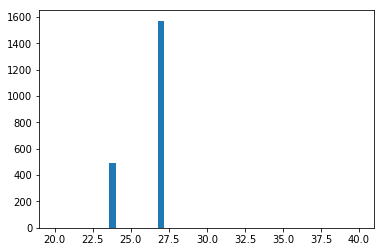

In [20]:
plt.hist(period_lengths_us, range=(20, 40), bins=50)
plt.show()

Let's demodulate the signal.
Clock periods shorter than 40us are combined into a long pulse, longer periods produce a gap.

In [21]:
demodulated = []
current_pulse_length = 0
for l in period_lengths_us:
    if l < 40:
        current_pulse_length += l
    else:
        demodulated.append([current_pulse_length, l])
        current_pulse_length = 0
demodulated = np.asarray(demodulated)

The first value in each row is the time the 40 kHz signal was active, the second value is the pause that followed. You should be able to identify the individual data frames. Often data frames start with a long start signal and end with a rather large gap.

In [22]:
demodulated

array([[  8993.43,   4505.12],
       [   557.66,    579.28],
       [   554.48,    579.28],
       [   554.48,   1686.73],
       [   554.49,    579.28],
       [   554.54,    579.28],
       [   554.5 ,    579.3 ],
       [   554.46,    579.29],
       [   554.5 ,   1686.73],
       [   554.54,   1686.73],
       [   554.49,    579.28],
       [   554.44,    579.28],
       [   554.49,   1686.74],
       [   554.47,   1686.74],
       [   554.51,   1686.74],
       [   554.46,   1686.75],
       [   554.48,   1686.73],
       [   554.51,    579.28],
       [   557.66,    579.28],
       [   554.46,   1686.73],
       [   554.47,    579.28],
       [   554.48,    579.28],
       [   554.52,   1686.74],
       [   554.52,    579.28],
       [   554.48,    579.29],
       [   554.47,   1686.74],
       [   554.5 ,   1686.74],
       [   554.47,    579.28],
       [   554.46,   1686.74],
       [   554.46,   1686.73],
       [   554.49,    579.29],
       [   554.49,   1686.73],
       [

You should now be able to identify the individual symbols in the demodulated data and decode your IR remote.